In [1]:
# Imports
import pandas
import random
import math
import numpy
import seaborn

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors

from datetime import datetime

In [2]:
# Load data
data = pandas.read_csv("data_for_student_case.csv", sep=',')

In [3]:
# Class containing the rank swapping logic
class rankSwap:
    # dataset : the dataset to be rank swapped
    # p : the amount of neighbours of an entry considered in the swapping (on each side)
    # indices : the list of names of columns to perform the rank swapping on
    # keyIndex : the name of the index to sort the data on before presentation
    def __init__(self, dataset, p, indices, keyIndex):
        self.dataset = dataset
        self.p = p

        self.swapRanks(indices, keyIndex)

    # indicesList : the list of names of columns being rank swapped
    def swapRanks(self, indicesList, keyIndex):
        for index in indicesList:
            self.sortOnAttribute(index)
            self.dataset[index] = self.swapRanksInColumn(self.dataset[index])

        self.sortOnAttribute(keyIndex)

    # swap ranks in a certain column
    def swapRanksInColumn(self, column):
        arr = column.to_numpy()

        for i in range(self.p, len(self.dataset) - self.p):
            seed = math.ceil(random.random() *  2 * self.p)
            iPrime = i - self.p + seed

            # swap
            temp = arr[i]
            arr[i] = arr[iPrime]
            arr[iPrime] = temp

            print(i)

        return column

    # sort the dataset on a certain column
    def sortOnAttribute(self, index):
        self.dataset = self.dataset.sort_values(index)

In [4]:
data

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,482729,2015-11-03 18:57:01,SE,visadebit,453903.0,48100.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:21:58,SwedenAccount,email135821,ip125573,card83162
290378,482731,2015-11-03 08:12:14,SE,mcdebit,554501.0,195000.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:31:24,SwedenAccount,email259702,ip202029,card131519
290379,482732,2015-11-03 08:12:14,SE,visadebit,453903.0,52500.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:41:40,SwedenAccount,email32927,ip229869,card142173
290380,482733,2015-11-03 18:56:44,SE,mcdebit,554501.0,87700.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:50:07,SwedenAccount,email97400,ip200721,card141579


In [21]:
### PREPROCESSING
df = data.copy()

# Drop all the rows that have refused as transaction since we don't know if it's fraud or not.
df = df[df['simple_journal'] != 'Refused']

# Map non fraud transactions and fraud to 0 and 1 respectively.
categories = {'Settled': 0, 'Chargeback' : 1}
df['simple_journal'] = df['simple_journal'].map(categories)

# Change the creation date to datetime to use later.
df['creationdate'] = pandas.to_datetime(df['creationdate'])

# Use currency code + amount to convert all the amounts to the same currency code (EUR)
currencycode_to_eur = {'GBP' : 0.86863, 'AUD' : 1.5581, 'SEK' : 10.1640, 'MXN' : 24.2345, 'NZD' : 1.6738}
df['amount'] = df['amount'] / (df['currencycode'].map(lambda x : currencycode_to_eur[x]))

# apply rank swapping
swap = rankSwap(df, 20, [], 'txid') #'currencycode', 'bin', 'amount'], 'txid')
df = swap.dataset

# drop irrelevant features
df = df.drop(columns=['txid', 'bookingdate', 'issuercountrycode', 'shoppercountrycode', 'creationdate', 'mail_id','ip_id', 'card_id'])

# one hot encode categorical colummns
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoding = pandas.DataFrame(encoder.fit_transform(df[['txvariantcode', 'currencycode', 'shopperinteraction', 'cardverificationcodesupplied', 'accountcode']]).toarray())
df = df.join(encoding)

df = df.drop(columns=['txvariantcode', 'currencycode', 'shopperinteraction', 'cardverificationcodesupplied', 'accountcode'])

# drop NaN values
df = df.dropna()

df

,bin,amount,simple_journal,cvcresponsecode,0,1,2,3,4,5,...,18,19,20,21,22,23,24,25,26,27
0,530056.0,2673.874023,1,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,547046.0,1852.730611,1,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,528843.0,6185.396852,1,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,547146.0,4534.857331,1,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,477291.0,3709.587571,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237031,446291.0,8168.034721,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
237032,454742.0,5059.691698,0,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
237033,446238.0,7592.415643,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
237034,552213.0,6360.590815,0,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [22]:
### CREATING SETS FOR TRAINING AND TESTING

# get labels
labels = df['simple_journal']
df = df.drop(columns=['simple_journal'])

# split
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size = .2, random_state = 42)

# SMOTE fraud cases to counter class imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [23]:
### TRAIN CLASSIFIERS

# import classifiers
#from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import LogisticRegression

# classify
#clf = SVC(gamma='auto')
clf = RandomForestClassifier(max_depth=2, random_state=0)
#clf = KNeighborsClassifier(n_ndf_transformedeighbors=100)
#clf = LogisticRegression(random_state=42, max_iter = 1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     43105
           1       0.02      0.90      0.03        61

    accuracy                           0.92     43166
   macro avg       0.51      0.91      0.50     43166
weighted avg       1.00      0.92      0.96     43166



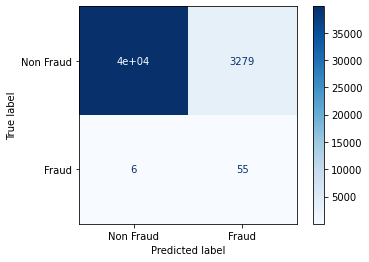

In [24]:
# evaluate
from sklearn.metrics import classification_report, plot_confusion_matrix

print(classification_report(y_test, y_pred))

class_names = ['Non Fraud', 'Fraud']
plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues, display_labels=class_names)

In [19]:
labels.sum()

315